# RNN from scratch, only using numpy
#### By: Teddy Ordoñez


#### Imports

In [1]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#### Defining RNN architecture

The RNN will have a learning rate of 0.001, the sequence length of the sin wave is 50, the max number os epochs will be 25, the hidden dimension will have a size of 100, output dimension will have a size of 1, backpropagating the error for every sequence, with a max and min values of 10 and -10, respectively

In [2]:
learning_rate = 0.0001
sequence_length = 50
epochs_max = 10
hidden_dimension = 100
output_dimension = 1
bptt = 5   # backpropagating the error, change value to sequence_length (50)
min_clip_val = -10
max_clip_val = 10

#### Activation Function

For this RNN, we will be using Sigmoid Function as our activation function

In [3]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

#### Loss Calculation

Creating a Loss Calculation function. Which will receive input (**X**) and result (**Y**) matrices, input to hidden layer weigths (**U**), hidden to output layer weigths (**V**) and hidden-to-hidden weigths (**W**). 

In [4]:
# Where X = data matrix, Y = output matrix, U = input to hidden weigths, V = hidden to output weights and W = hidden to hidden weights
def loss_calculation(X, Y, U, V, W):
    loss = 0.0
    
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]   # x and y will represent a specific data point
        previous_activation = np.zeros((hidden_dimension, 1))   # previous activation needs to have the same size as the hidden dimension

        for timestep in range(sequence_length): # Sequence length determines the timestep
            new_input = np.zeros(x.shape)   # New input will hold every data point in x with the shape of x. Doing this for every step in the sequence, forwards pass.
            new_input[timestep] = x[timestep]   # New input now has the same value os data entry for that timestep. New input has a single input for that timestep
            multiplied_u = np.dot(U, new_input) # Multipliying the inputs times the weights
            multiplied_w = np.dot(W, previous_activation)   # Multiplying the previous activation values times the hidden-to-hidden weigths
            sum_mulu_mulw = multiplied_u + multiplied_w     # Suming the products of the inputs and activations with their respective weigths
            new_activation = sigmoid(sum_mulu_mulw)     # Activating that sum
            multiplied_v = np.dot(V, new_activation)    # Multiplying the activated values time the weights of hidden-to-output layer
            previous_activation = new_activation        # The current activations becomes the previous activation for the next iteration
        
        loss_per_input = float((y - multiplied_v) ** 2 / 2)     # Calculating the Mean Squared Error (MSE)
        loss += loss_per_input      # Adding the input loss to the total loss

    return loss, new_activation     # Returning the total loss and activation values


#### Layer Activation Calculation

With this function we will be calculating the activation values of the recurrent layers created by the recurrance relation of the RNN. This function receives input matrix (**x**), input to hidden weights (**U**), hidden to output weights (**V**), hidden to hidden weights (**W**) and the previous activation values(**previous_activation**)

In [5]:
# Where X = data matrix, U = input to hidden weigths, V = hidden to output weights and W = hidden to hidden weights and previous_activation = previous activation for the final layer
def layer_activation_calc(x, U, V, W, previous_activation):
    layers = []     # Creating a list of empty layers before iterating for each timestep
    for timestep in range(sequence_length):
        new_input = np.zeros(x.shape)   # New input will begin with 0 in a x-like shape 
        new_input[timestep] = x[timestep]  # New input now has the same value os data entry for that timestep. New input has a single input for that timestep
        multiplied_u = np.dot(U, new_input)     # Multiplying inputs times their weights in relation to hidden layer
        multiplied_w = np.dot(V, previous_activation)    # Multipliying previous activation times hidden to output layer weights
        sum_mulu_mulw = multiplied_u + multiplied_w      # Adding both results
        activation = sigmoid(sum_mulu_mulw)     # Activating result
        multiplied_v = np.dot(V, activation)    # Multiplying the activated results times hidden to output weights
        layers.append({'activation' : activation, 'previous_activation' : previous_activation})     # Creating a dictionary containing the new activation and previous activation values
        previous_activation = activation    # Updating previous activation with the new activation

    return layers, multiplied_u, multiplied_w, multiplied_v     # Returning the recurrent layers, and multiplied U, W, and V matrices

#### Previous Hidden Layer Activation Differential

Since finding the differntial for the previous activation of the hidden layer needs to be performed several times, creating a function will help to keep the code cleaner. 
The fuction receives three parameters, first we need the sum of the weights (**sum_weigths**), the differential of the output layer (**ds**) and finally the weigths layer (**W**)

In [6]:
def previous_activation_differential(sum_weights, ds, W):
    d_sum_weights = sum_weights * (1 - sum_weights) * ds    # Calculating differential by mult the sum of the weights by its "inv" from 1, times the differential of the output layer
    d_mul_w = d_sum_weights * np.ones_like(ds)  # Differential of the hidden layerr output by multiplying diff of the sum by a matrix in the shape of the output layer diff
    return np.dot(np.transpose(W), d_mul_w)     # Returning the dot product of the hidden layer weigth and the differential created before

#### Backpropagation

We will use backpropagation to update the weights of our neural network. The function will receive eight parameters (all have been created before). **x** is the input matrix, **U** is input to hidden weigths, **V** is hidden to output weigths, **W** is hidden to hidden weights, **d_multiplied_v** is the differential for the last layer, **multiplied_u** and **multiplied_w** are the input values for the hidden layer, and finally **layers** is the list of layer activaitons

In [7]:
# Where X = data matrix, U = input to hidden weigths, V = hidden to output weights and W = hidden to hidden weights, d_multiplied_v = differential last layer, 
# multiplied_u = multiplied input to hidden values, multiplied_w = multiplied hidden to hidden values, and layers = layer activations
def backpropagation(x, U, V, W, d_multiplied_v, multiplied_u, multiplied_w, layers):
    dU = np.zeros(U.shape)      # These three lines prepare the variables that will hold the differential of U, V, and W
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
    dU_t = np.zeros(U.shape)      # These three lines prepare the variables that will hold the differential in the timestep of U, V, and W
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
    dU_i = np.zeros(U.shape)      # These two lines will hold the differentials of the backprop through time
    dW_i = np.zeros(W.shape)
    sum_mulu_mulw = multiplied_u + multiplied_w     # Adding input to hidden weigths and hidden to hidden weights
    dsv = np.dot(np.transpose(V), d_multiplied_v)   # Multiplying the transposedd matrix of V times the differential of V

    for timestep in range(sequence_length):
        dV_t  = np.dot(d_multiplied_v, np.transpose(layers[timestep]['activation'])) # Diff = last layer differential times last layer activation
        ds = dsv    # Copying the differential of the last layer into ds, since we are going to change it for this timestep
        d_previous_activation = previous_activation_differential(sum_mulu_mulw, ds, W)  # Getting differential of previous activation

        for j in range(timestep - 1, max(-1, timestep - bptt - 1), -1): # Backprop by looping through each prior timestep
            ds = dsv + d_previous_activation    # Agumenting the last layer differential
            d_previous_activation = previous_activation_differential(sum_mulu_mulw, ds, W)  # Calculating the previous activation in the previous timestep with the new differential
            dW_i = np.dot(W, layers[timestep]['previous_activation'])   # Calculating the differential for this recurrent timestep by mult hidden weigths time timestep's prev activation

            new_input = np.zeros(x.shape)   
            new_input[timestep] = x[timestep]   # New input is the current timestep
            dU_i = np.dot(U, new_input)     # Differential for te input layer for this recurrent timestep

            dU_t += dU_i        # Adding differential input and hidden values of the recurrent timestep
            dW_t += dW_i
        
        dU += dU_t      # Adding the differentials of each timestep to store them
        dV += dV_t
        dW += dW_t

        # Exploding gradients, if any differential is bigger or smalled than selected boundaries, change value to the boundary to avoid exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
       
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
    
    return dU, dV, dW

#### Training the RNN

This function will receive seven parameters. Weigth matrices (**U**, **V** and **W**). Training data (**X**) and results of those training data (**Y**). Validation input data (**X_val**) results for validating data (**Y_val**). Training will be held the **max_epochs** defined before

In [8]:
def train(U, V, W, X, Y, X_val, Y_val):
    for epoch in range(epochs_max):
        loss, previous_activation = loss_calculation(X, Y, U, V, W) # Calculating initial loss
        validation_loss, x = loss_calculation(X_val, Y_val, U, V, W)    # Check validation loss

        print(f'Epoch: {epoch + 1}, Loss: {loss}, Validation Loss: {validation_loss}')

        # Forward pass, actual training
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]       # Separating x and y values for training
            layers = []     # Creating an empty layers' list
            previous_activation = np.zeros((hidden_dimension, 1))   # Creating previous activation with the shape of hidden dimensions, 1

            layers, multiplied_u, multiplied_w, multiplied_v = layer_activation_calc(x, U, V, W, previous_activation)   # Calculating layers and multiplied weights

            # Backprop
            d_multiplied_v = multiplied_v - y   # Differentece between prediction
            dU, dV, dW = backpropagation(x, U, V, W, d_multiplied_v, multiplied_u, multiplied_w, layers)

            U -= learning_rate * dU     # These three lines update the weigths
            V -= learning_rate * dV
            W -= learning_rate * dW
    
    return U, V, W

#### Data Setup

In this section we will be preparing data do be fed to the RNN. We will be playing with a sine wave, since they are sequence data. The have a period of 2pi. Firstly, we need to define X to be 50 contiguous points in the searies and Y as the next datapoint in the sine wave. Training data will be defined as the first 100 points and validation as the next 50, because of this we will be creating a sine wave of 200 data points.

In [9]:
sine_wave = np.array([math.sin(x) for x in range(200)])

X = []  # Training data
Y = []

number_records = len(sine_wave) - sequence_length   # number_records = 200 - 50

for i in range(number_records - 50):    # X are 50 datapoint and Y are the 51st data point
    X.append(sine_wave[i:i + sequence_length])
    Y.append(sine_wave[i + sequence_length])

X = np.expand_dims(np.array(X), axis=2) # X will have a shape of 100 x 50 x 1
Y = np.expand_dims(np.array(Y), axis=1) # Y will have a sahpe of 100 x 1

X_validation = []
Y_validation = []
for i in range(number_records - sequence_length, number_records):
    X_validation.append(sine_wave[i:i + sequence_length])
    Y_validation.append(sine_wave[i + sequence_length])

X_validation = np.expand_dims(np.array(X_validation), axis=2) 
Y_validation = np.expand_dims(np.array(Y_validation), axis=1) 

In [10]:
np.random.seed(12161)   # For having reproductible results
U = np.random.uniform(0, 1, (hidden_dimension, sequence_length))    # input to hidden weigths
V = np.random.uniform(0, 1, (output_dimension, hidden_dimension))   # hidden to output weigths
W = np.random.uniform(0, 1, (hidden_dimension, hidden_dimension))   # hidden to hidden weigths
U.shape

(100, 50)

Epoch: 1, Loss: 132219.50990086797, Validation Loss: 66107.73179592531
Epoch: 2, Loss: 85800.72307067864, Validation Loss: 42898.72415489228
Epoch: 3, Loss: 49381.93624027209, Validation Loss: 24689.716513750416
Epoch: 4, Loss: 22963.14709973055, Validation Loss: 11480.70771518648
Epoch: 5, Loss: 6528.960175424226, Validation Loss: 3263.9837277981487
Epoch: 6, Loss: 86.93779259598563, Validation Loss: 43.37326423676404
Epoch: 7, Loss: 34.830310885011315, Validation Loss: 17.345609890701834
Epoch: 8, Loss: 34.97556196254322, Validation Loss: 17.421008112241648
Epoch: 9, Loss: 34.96629111757604, Validation Loss: 17.412960374103992
Epoch: 10, Loss: 34.97823495761949, Validation Loss: 17.421789912908302


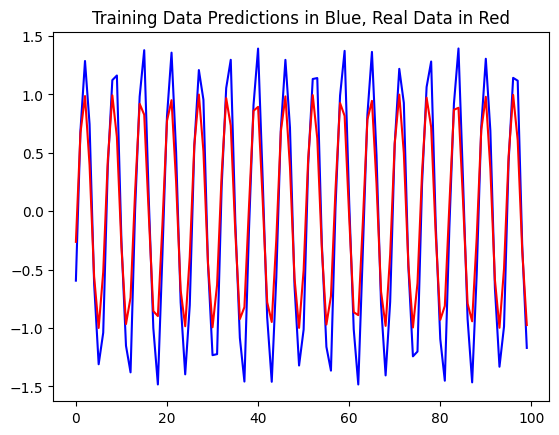

In [11]:
U, V, W = train(U, V, W, X, Y, X_validation, Y_validation)  # Training the RNN

# Predictions done with training data
predictions = []

for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    previous_activation = np.zeros((hidden_dimension, 1))

    for timestep in range(sequence_length):     # Forward pass
        multiplied_u = np.dot(U, x)
        multiplied_w = np.dot(W, previous_activation)
        sum_multiplied_weigths = multiplied_u + multiplied_w
        activation = sigmoid(sum_multiplied_weigths)
        multiplied_v = np.dot(V, activation)
        previous_activation = activation
    predictions.append(multiplied_v)

predictions = np.array(predictions)

plt.plot(predictions[:, 0,0], 'b')
plt.plot(Y[:, 0], 'r')
plt.title("Training Data Predictions in Blue, Real Data in Red")
plt.show()

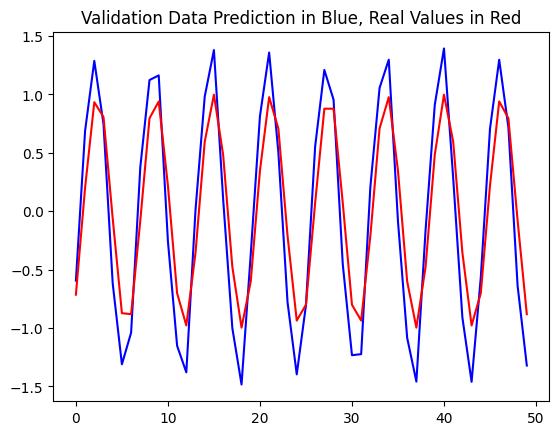

Root Mean Sqaure Error: 0.3957471754481206


In [12]:
validation_predictions = []    # Predictions on the validation set

for i in range(Y_validation.shape[0]):
    x, y = X[i], Y[i]
    previous_activation = np.zeros((hidden_dimension, 1))

    for timestep in range(sequence_length):     # Forward passing
        multiplied_u = np.dot(U, x)
        multiplied_w = np.dot(W, previous_activation)
        sum_multiplied_weigths = multiplied_u + multiplied_w
        activation = sigmoid(sum_multiplied_weigths)
        multiplied_v = np.dot(V, activation)
        previous_activation = activation
    validation_predictions.append(multiplied_v)

validation_predictions =  np.array(validation_predictions)

plt.plot(validation_predictions[:, 0 , 0], 'b')     # Blue for validation prediction
plt.plot(Y_validation[:, 0], 'r')       # Red for true validation values
plt.title('Validation Data Prediction in Blue, Real Values in Red')
plt.show()

# Calculating RMSE
rmse = math.sqrt(mean_squared_error(Y_validation[:, 0], validation_predictions[:, 0, 0]))
print(f'Root Mean Sqaure Error: {rmse}')